In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math
import itertools
from sklearn.metrics import mean_squared_error

In [2]:
df_raw = pd.read_csv('de_train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv('de_test.csv', low_memory=False, parse_dates=['date'], index_col=['date'])

In [3]:
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [4]:
df_test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [5]:
print("Train and Test shape are {} and {} respectively".format(df_raw.shape, df_test.shape))

Train and Test shape are (913000, 3) and (45000, 3) respectively


In [6]:
#### Seasonality Check
# preparation: input should be float type
df_raw['sales'] = df_raw['sales'] * 1.0

In [7]:
# Preparing data by stores
sales_a = df_raw[df_raw.store==2]['sales'].sort_index(ascending = True)
sales_b = df_raw[df_raw.store==3]['sales'].sort_index(ascending = True)
sales_c = df_raw[df_raw.store==1]['sales'].sort_index(ascending = True)
sales_d = df_raw[df_raw.store==4]['sales'].sort_index(ascending = True)

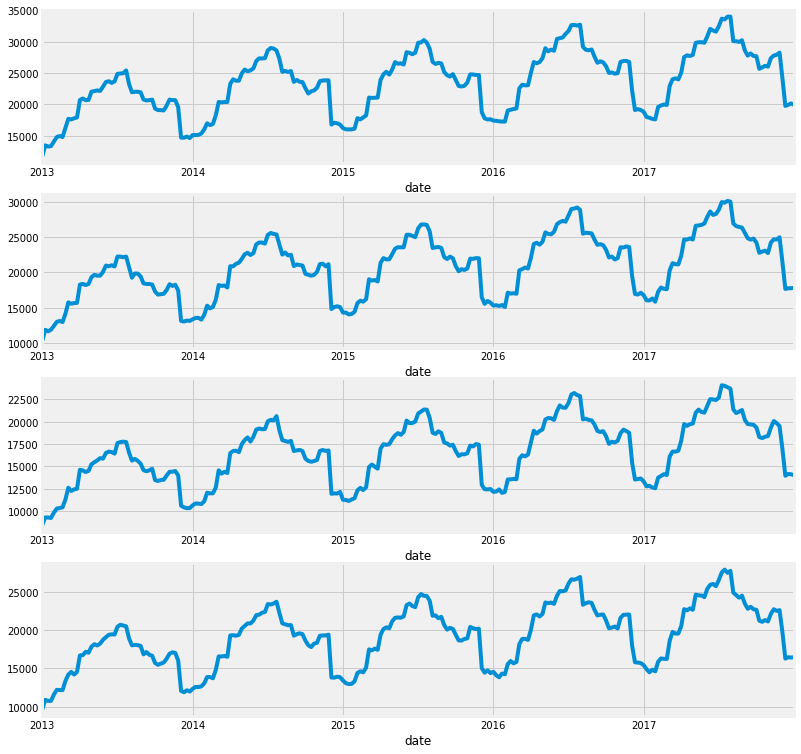

In [16]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize = (12,13))

# data is sampled by day. To plot it it need to be upsampled to weekly.

sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

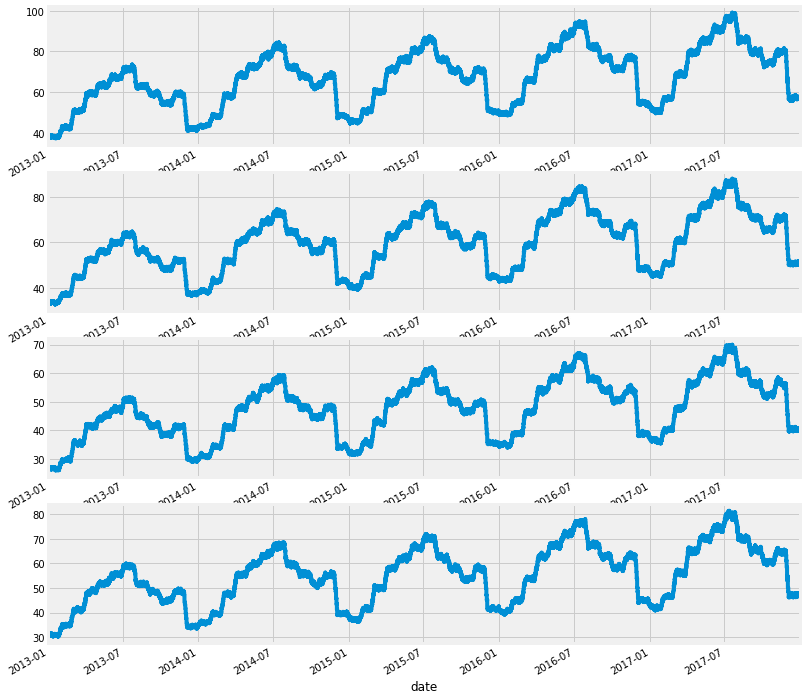

In [8]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize = (12,13))

# Seasonal decomposition of the sales dataset (method =  additive)

decomposition_a = seasonal_decompose(sales_a , model='additive' , freq = 365)
decomposition_a.trend.plot(ax = ax1)

decomposition_b = seasonal_decompose(sales_b , model='additive' , freq = 365)
decomposition_b.trend.plot(ax = ax2)

decomposition_c = seasonal_decompose(sales_c , model='additive' , freq = 365)
decomposition_c.trend.plot(ax = ax3)

decomposition_d = seasonal_decompose(sales_d , model='additive' , freq = 365)
decomposition_d.trend.plot(ax = ax4)

In [9]:
# Total Sales

date_sales = df_raw.drop(['store','item'],axis=1).copy()

In [49]:
y = date_sales['sales'].resample('MS').mean()
y['2017':]

date
2017-01-01    39.826194
2017-02-01    44.383500
2017-03-01    53.075290
2017-04-01    62.590800
2017-05-01    65.850710
2017-06-01    70.974933
2017-07-01    75.573742
2017-08-01    66.219548
2017-09-01    62.350867
2017-10-01    57.494194
2017-11-01    61.922467
2017-12-01    44.849677
Freq: MS, Name: sales, dtype: float64

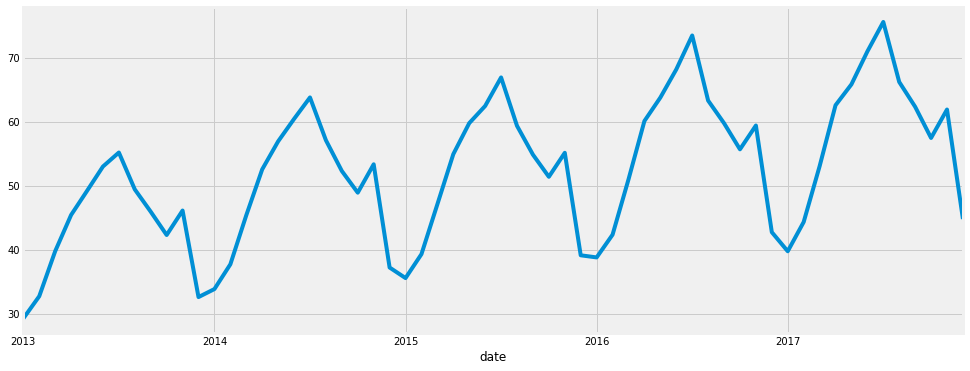

In [50]:
y.plot(figsize = (15,6))

<Figure size 432x288 with 0 Axes>

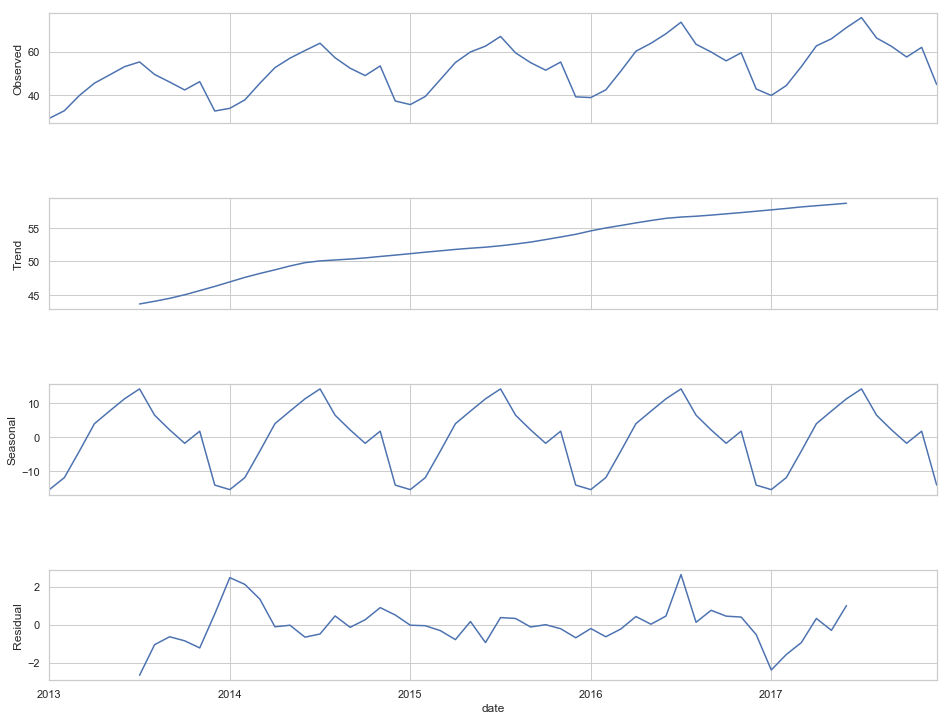

In [102]:
decomposition = seasonal_decompose(y , model='additive')

fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 12)

In [61]:
df_raw = df_raw.reset_index()
df_test = df_test.reset_index()

In [66]:
df_p = df_raw.copy()

In [69]:
#Fucntion to convert date column to date time attribute to plot pivot figures

import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_p,'date',False)


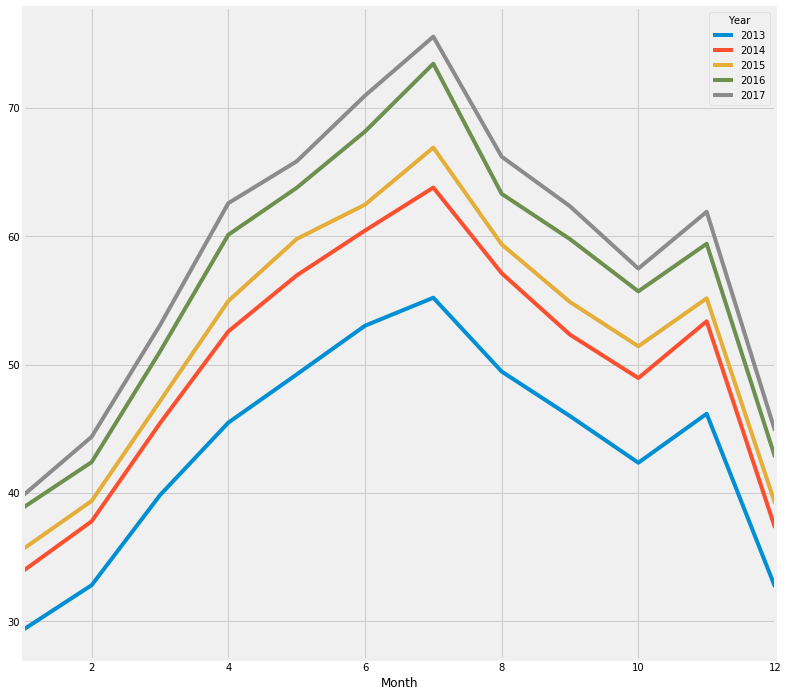

In [70]:
pivoted = pd.pivot_table(df_p, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

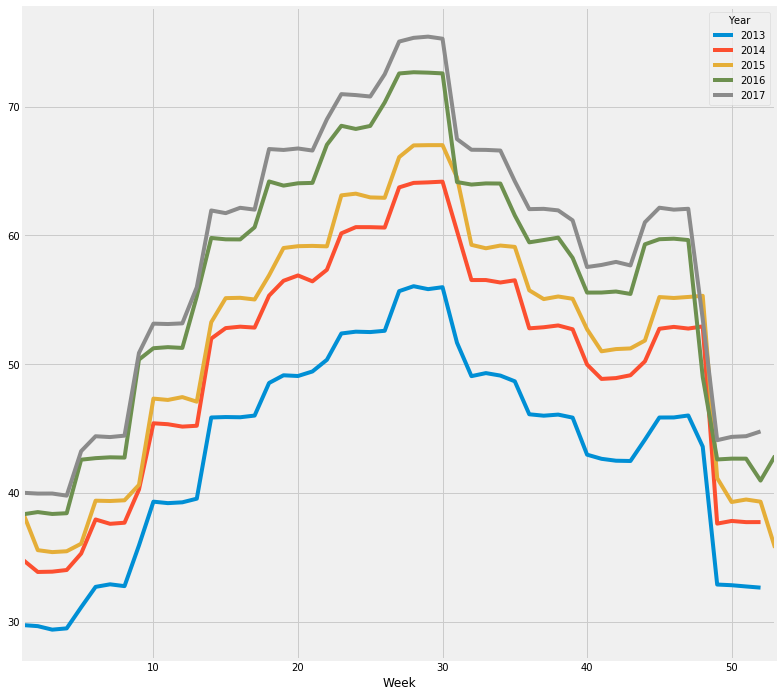

In [72]:
pivoted = pd.pivot_table(df_p, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

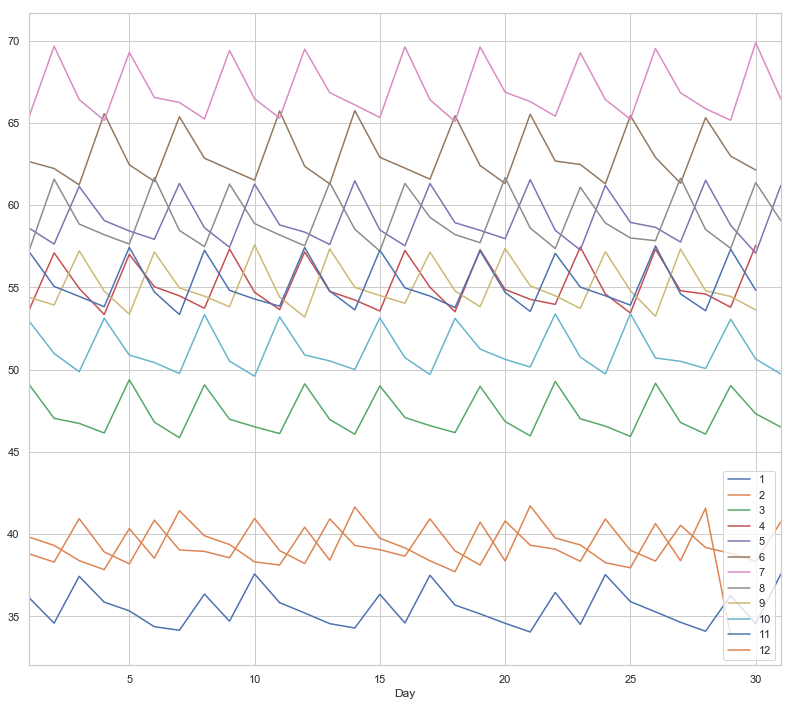

In [100]:
pivoted = pd.pivot_table(df_p, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12))
plt.legend(loc = 'lower right')

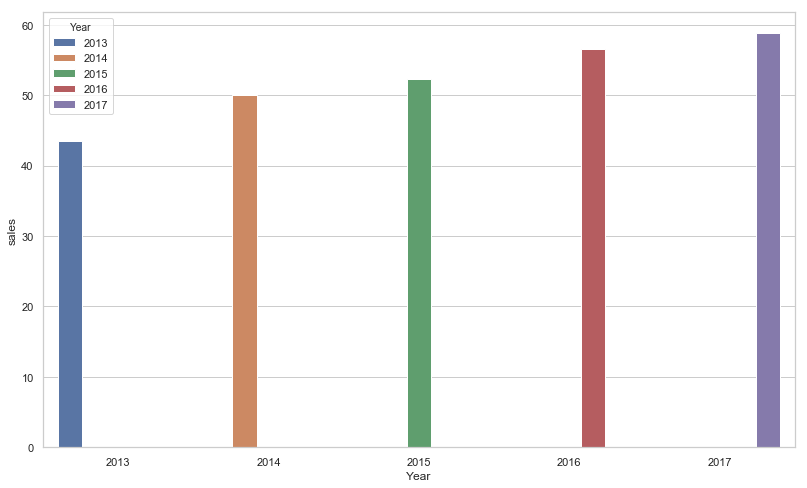

In [77]:
temp_1 = df_p.groupby(['Year'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.set(style="whitegrid")
sns.barplot('Year','sales',data = temp_1, hue='Year');

In [97]:
values = list(range(len(temp_1.Year)))
fig1 = go.Figure(go.Bar(x = temp_1.Year, y = temp_1.sales,marker_color = values ,text = temp_1.sales,textposition='auto'))
fig1.update_layout(title_text = 'Total sales by Year')
fig1.show()

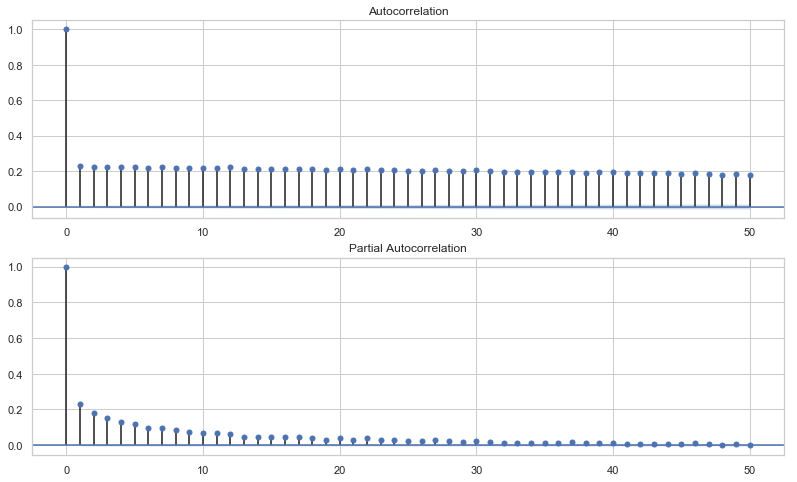

In [110]:
# figure for subplots
plt.figure(figsize = (12, 8))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf and pacf for A
plt.subplot(211); plot_acf(sales_a, lags = 50, ax = plt.gca())
plt.subplot(212); plot_pacf(sales_a, lags = 50, ax = plt.gca())
plt.show()

# SARIMA forecasting

In [112]:
# SARIMA forecasting

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [119]:
cnt = 0
h = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            h += [[param, param_seasonal, results.aic]]
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
                
        except:
            continue

Current Iter - 1, ARIMA(0, 0, 0)x(0, 0, 0, 12) 12 - AIC:639.3903169231556
Current Iter - 2, ARIMA(0, 0, 0)x(0, 0, 1, 12) 12 - AIC:515.545063887946
Current Iter - 3, ARIMA(0, 0, 0)x(0, 1, 0, 12) 12 - AIC:272.69049432052384
Current Iter - 4, ARIMA(0, 0, 0)x(0, 1, 1, 12) 12 - AIC:1226.9538454660483
Current Iter - 5, ARIMA(0, 0, 0)x(0, 2, 0, 12) 12 - AIC:182.93318901930823
Current Iter - 6, ARIMA(0, 0, 0)x(1, 0, 0, 12) 12 - AIC:214.87722464483306
Current Iter - 7, ARIMA(0, 0, 0)x(1, 0, 1, 12) 12 - AIC:194.2026210978883
Current Iter - 8, ARIMA(0, 0, 0)x(1, 1, 0, 12) 12 - AIC:159.12960769429364
Current Iter - 9, ARIMA(0, 0, 0)x(1, 1, 1, 12) 12 - AIC:1173.0606126763435
Current Iter - 10, ARIMA(0, 0, 0)x(1, 2, 0, 12) 12 - AIC:69.40423186123914
Current Iter - 11, ARIMA(0, 0, 0)x(2, 0, 0, 12) 12 - AIC:100.56580160005477
Current Iter - 12, ARIMA(0, 0, 0)x(2, 0, 1, 12) 12 - AIC:96.77925890266438
Current Iter - 13, ARIMA(0, 0, 0)x(2, 1, 0, 12) 12 - AIC:49.39821838607181
Current Iter - 14, ARIMA(0, 

Current Iter - 112, ARIMA(0, 2, 1)x(1, 0, 1, 12) 12 - AIC:139.23125143121118
Current Iter - 113, ARIMA(0, 2, 1)x(1, 1, 0, 12) 12 - AIC:104.88137079593186
Current Iter - 114, ARIMA(0, 2, 1)x(1, 1, 1, 12) 12 - AIC:1283.6486176293624
Current Iter - 115, ARIMA(0, 2, 1)x(1, 2, 0, 12) 12 - AIC:78.22156636310022
Current Iter - 116, ARIMA(0, 2, 1)x(2, 0, 0, 12) 12 - AIC:101.66087309046821
Current Iter - 117, ARIMA(0, 2, 1)x(2, 0, 1, 12) 12 - AIC:102.84085595434098
Current Iter - 118, ARIMA(0, 2, 1)x(2, 1, 0, 12) 12 - AIC:75.16175393673602
Current Iter - 119, ARIMA(0, 2, 1)x(2, 1, 1, 12) 12 - AIC:939.8346943254053
Current Iter - 120, ARIMA(0, 2, 1)x(2, 2, 0, 12) 12 - AIC:39.952149447203695
Current Iter - 121, ARIMA(0, 2, 2)x(0, 0, 0, 12) 12 - AIC:379.2976443370531
Current Iter - 122, ARIMA(0, 2, 2)x(0, 0, 1, 12) 12 - AIC:269.39710776832896
Current Iter - 123, ARIMA(0, 2, 2)x(0, 1, 0, 12) 12 - AIC:140.7882448636783
Current Iter - 124, ARIMA(0, 2, 2)x(0, 1, 1, 12) 12 - AIC:1192.9301125036686
Curr

Current Iter - 222, ARIMA(1, 1, 2)x(2, 0, 1, 12) 12 - AIC:69.89168209803805
Current Iter - 223, ARIMA(1, 1, 2)x(2, 1, 0, 12) 12 - AIC:47.922403597371215
Current Iter - 224, ARIMA(1, 1, 2)x(2, 1, 1, 12) 12 - AIC:945.9997603320055
Current Iter - 225, ARIMA(1, 1, 2)x(2, 2, 0, 12) 12 - AIC:27.256827052492394
Current Iter - 226, ARIMA(1, 2, 0)x(0, 0, 0, 12) 12 - AIC:398.7159569562058
Current Iter - 227, ARIMA(1, 2, 0)x(0, 0, 1, 12) 12 - AIC:284.53287238890005
Current Iter - 228, ARIMA(1, 2, 0)x(0, 1, 0, 12) 12 - AIC:162.38997656482388
Current Iter - 229, ARIMA(1, 2, 0)x(0, 1, 1, 12) 12 - AIC:1230.684267338694
Current Iter - 230, ARIMA(1, 2, 0)x(0, 2, 0, 12) 12 - AIC:145.2530674528963
Current Iter - 231, ARIMA(1, 2, 0)x(1, 0, 0, 12) 12 - AIC:158.95510457635865
Current Iter - 232, ARIMA(1, 2, 0)x(1, 0, 1, 12) 12 - AIC:161.31298831297576
Current Iter - 233, ARIMA(1, 2, 0)x(1, 1, 0, 12) 12 - AIC:115.18678383287812
Current Iter - 234, ARIMA(1, 2, 0)x(1, 1, 1, 12) 12 - AIC:1235.6102331593013
Curr

Current Iter - 332, ARIMA(2, 1, 1)x(0, 0, 1, 12) 12 - AIC:271.9496232643638
Current Iter - 333, ARIMA(2, 1, 1)x(0, 1, 0, 12) 12 - AIC:142.195400283124
Current Iter - 334, ARIMA(2, 1, 1)x(0, 1, 1, 12) 12 - AIC:2282.9941970392674
Current Iter - 335, ARIMA(2, 1, 1)x(0, 2, 0, 12) 12 - AIC:127.3732866780858
Current Iter - 336, ARIMA(2, 1, 1)x(1, 0, 0, 12) 12 - AIC:137.364487385047
Current Iter - 337, ARIMA(2, 1, 1)x(1, 0, 1, 12) 12 - AIC:140.411327395601
Current Iter - 338, ARIMA(2, 1, 1)x(1, 1, 0, 12) 12 - AIC:93.99117583858
Current Iter - 339, ARIMA(2, 1, 1)x(1, 1, 1, 12) 12 - AIC:nan
Current Iter - 340, ARIMA(2, 1, 1)x(1, 2, 0, 12) 12 - AIC:47.58411970851947
Current Iter - 341, ARIMA(2, 1, 1)x(2, 0, 0, 12) 12 - AIC:69.55549000606621
Current Iter - 342, ARIMA(2, 1, 1)x(2, 0, 1, 12) 12 - AIC:69.93818689361734
Current Iter - 343, ARIMA(2, 1, 1)x(2, 1, 0, 12) 12 - AIC:44.31643194116325
Current Iter - 344, ARIMA(2, 1, 1)x(2, 1, 1, 12) 12 - AIC:nan
Current Iter - 345, ARIMA(2, 1, 1)x(2, 2, 0, 

In [131]:
# The combination of hyperparameters ((p,d,q),(P,D,Q,m)) along with the AIC is stored in h
h.sort(key = lambda x:x[2])

# 3 Combination that yeilds lowest AIC values are as follows :
h[:3]

[[(2, 0, 2), (2, 2, 0, 12), 17.459959634135732],
 [(2, 1, 0), (2, 2, 0, 12), 24.429306551675314],
 [(2, 0, 2), (2, 1, 0, 12), 28.58391337180839]]

In [155]:
# Training SARIMA 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 1),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [156]:
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4013      0.415      0.966      0.334      -0.413       1.216
ar.L2          0.6486      0.522      1.244      0.214      -0.374       1.671
ma.L1         -1.0000   9068.265     -0.000      1.000   -1.78e+04    1.78e+04
ar.S.L12      -0.8979      0.297     -3.019      0.003      -1.481      -0.315
ar.S.L24       0.1436      0.218      0.659      0.510      -0.284       0.571
sigma2         0.2396   2172.858      0.000      1.000   -4258.483    4258.963


In [187]:
# Calculating Mean Squared Error
y_forecasted = pred.predicted_mean
y_act = y['2017-01-01':]

mse = mean_squared_error(y_act,y_forecasted)

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.73


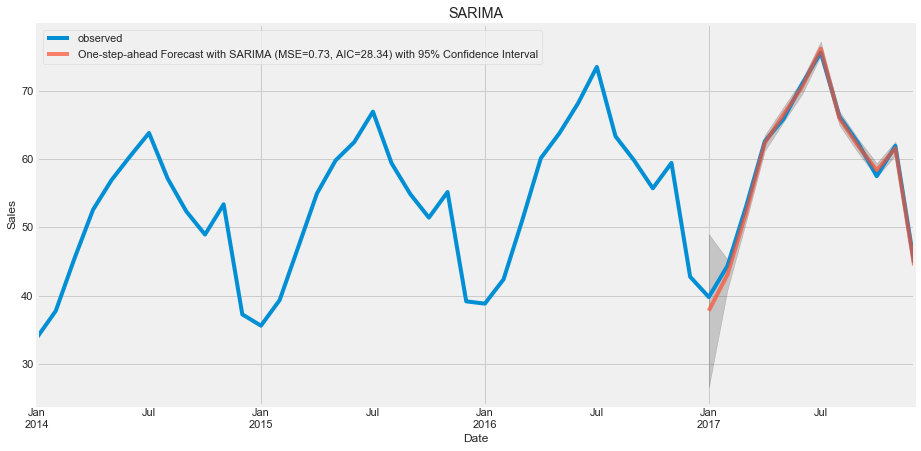

In [193]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step-ahead Forecast with SARIMA (MSE={:0.2f}, AIC={:0.2f}) with 95% Confidence Interval'.format(mse, results.aic), alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
ax.set_title("SARIMA");

# Holt-Winter's Seasonal Smoothing

In [189]:
# Holt-Winter's Seasonal Smoothing

model = ExponentialSmoothing(y, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(y, trend="add", seasonal="add", seasonal_periods=12, damped=True)

fit = model.fit()
pred_hw = fit.predict(start=pd.to_datetime('2017-01-01'))
fit2 = model2.fit()
pred_hw2 = fit2.predict(start=pd.to_datetime('2017-01-01'))

In [184]:
# Calculating Mean Squared Error
mse_hw = mean_squared_error(y['2017-01-01':],pred_hw)
mse_hw2 = mean_squared_error(y['2017-01-01':],pred_hw2)
print('The Mean Squared Error of our forecasts is {} w/o damping'.format(round(mse_hw, 2)))
print('The Mean Squared Error of our forecasts is {} with damping'.format(round(mse_hw2, 2)))

The Mean Squared Error of our forecasts is 2.19 w/o damping
The Mean Squared Error of our forecasts is 2.05 with damping


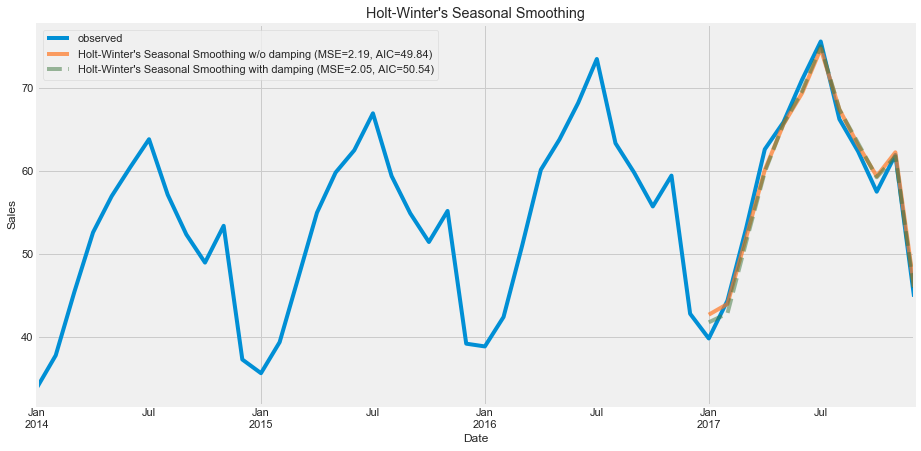

In [191]:
ax = y['2014':].plot(label='observed')
pred_hw.plot(ax=ax, label="Holt-Winter's Seasonal Smoothing w/o damping (MSE={:0.2f}, AIC={:0.2f})".format(mse_hw, fit.aic), alpha=.7, color='#ff7823', figsize=(14, 7))
pred_hw2.plot(ax=ax, label="Holt-Winter's Seasonal Smoothing with damping (MSE={:0.2f}, AIC={:0.2f})".format(mse_hw2, fit2.aic),linestyle='--', alpha=.5, color='#3c763d', figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
ax.set_title("Holt-Winter's Seasonal Smoothing");